In [1]:
import sys

In [2]:
!{sys.executable} -m pip install rdflib

In [60]:
from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
import networkx as nx
from networkx import Graph as NXGraph
import matplotlib.pyplot as plt
import statistics
import collections
import io
import pandas as pd

In [7]:
from SPARQLWrapper import SPARQLWrapper, JSON, CSV

In [3]:
prefixes = '''
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX vg: <http://biohackathon.org/resource/vg#>
PREFIX uniprotkb: <http://purl.uniprot.org/uniprot/>
PREFIX uberon: <http://purl.obolibrary.org/obo/uo#>
PREFIX taxon: <http://purl.uniprot.org/taxonomy/>
PREFIX sp: <http://spinrdf.org/sp#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX schema: <http://schema.org/>
PREFIX sachem: <http://bioinfo.uochb.cas.cz/rdf/v1.0/sachem#>
PREFIX rh: <http://rdf.rhea-db.org/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX pubmed: <http://rdf.ncbi.nlm.nih.gov/pubmed/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX patent: <http://data.epo.org/linked-data/def/patent/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX orthodbGroup: <http://purl.orthodb.org/odbgroup/>
PREFIX orthodb: <http://purl.orthodb.org/>
PREFIX orth: <http://purl.org/net/orth#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX np: <http://nextprot.org/rdf#>
PREFIX nextprot: <http://nextprot.org/rdf/entry/>
PREFIX mnx: <https://rdf.metanetx.org/schema/>
PREFIX mnet: <https://rdf.metanetx.org/mnet/>
PREFIX mesh: <http://id.nlm.nih.gov/mesh/>
PREFIX lscr: <http://purl.org/lscr#>
PREFIX lipidmaps: <https://www.lipidmaps.org/rdf/>
PREFIX keywords: <http://purl.uniprot.org/keywords/>
PREFIX insdcschema: <http://ddbj.nig.ac.jp/ontologies/nucleotide/>
PREFIX insdc: <http://identifiers.org/insdc/>
PREFIX identifiers: <http://identifiers.org/>
PREFIX glyconnect: <https://purl.org/glyconnect/>
PREFIX glycan: <http://purl.jp/bio/12/glyco/glycan#>
PREFIX genex: <http://purl.org/genex#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX eunisSpecies: <http://eunis.eea.europa.eu/rdf/species-schema.rdf#>
PREFIX ensembltranscript: <http://rdf.ebi.ac.uk/resource/ensembl.transcript/>
PREFIX ensemblterms: <http://rdf.ebi.ac.uk/terms/ensembl/>
PREFIX ensemblprotein: <http://rdf.ebi.ac.uk/resource/ensembl.protein/>
PREFIX ensemblexon: <http://rdf.ebi.ac.uk/resource/ensembl.exon/>
PREFIX ensembl: <http://rdf.ebi.ac.uk/resource/ensembl/>
PREFIX ec: <http://purl.uniprot.org/enzyme/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dc: <http://purl.org/dc/terms/>
PREFIX chebislash: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebihash: <http://purl.obolibrary.org/obo/chebi#>
PREFIX cco: <http://rdf.ebi.ac.uk/terms/chembl#>
PREFIX busco: <http://busco.ezlab.org/schema#>
PREFIX bibo: <http://purl.org/ontology/bibo/>
PREFIX allie: <http://allie.dbcls.jp/>
PREFIX SWISSLIPID: <https://swisslipids.org/rdf/SLM_>
PREFIX GO: <http://purl.obolibrary.org/obo/GO_>
PREFIX ECO: <http://purl.obolibrary.org/obo/ECO_>
PREFIX CHEBI: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX up: <http://purl.uniprot.org/core/>
PREFIX faldo: <http://biohackathon.org/resource/faldo#>
'''



In [4]:
query = '''
SELECT ?protein ?transcript ?ensprotein ?gene
WHERE 
{
  ?protein rdfs:seeAlso ?transcript .
  ?protein a up:Protein .
  ?protein up:reviewed true .
  ?protein up:organism taxon:9606 .
  ?transcript a up:Transcript_Resource .
  ?transcript up:translatedTo ?ensprotein .
  ?transcript up:transcribedFrom ?gene .
 
}
'''

In [15]:
q=f'''
{prefixes}
{query}
LIMIT 10
'''

In [77]:
class KnowledgeGraph():
    def __init__(self, sparql_endpoint='http://sparql.uniprot.org/sparql'):
        self.sparql_endpoint = sparql_endpoint
    def query_sparql(self, q, output_format='json'):
        sparql = SPARQLWrapper(self.sparql_endpoint)
        sparql.setQuery(q)
        sparql.setReturnFormat(output_format)
        results = sparql.query()
        res = results.convert()
        return res
    def query_to_pandas(self, q):
        res = self.query_sparql(q, output_format='csv')
        df = pd.read_csv(io.BytesIO(res), sep=",")
        return df
    def query_to_graph(self, q):
        g = self.query_sparql(q, output_format='rdf')
        return g

In [78]:
kg = KnowledgeGraph()

## Graph query

In [14]:
query = '''
CONSTRUCT {
  ?transcript up:translatedTo ?ensprotein .
  ?transcript up:transcribedFrom ?gene .
}
WHERE 
{
  ?protein rdfs:seeAlso ?transcript .
  ?protein a up:Protein .
  ?protein up:reviewed true .
  ?protein up:organism taxon:9606 .
  ?transcript a up:Transcript_Resource .
  ?transcript up:translatedTo ?ensprotein .
  ?transcript up:transcribedFrom ?gene .
 
}
'''

In [65]:
q=f'''
{prefixes}
{query}
LIMIT 10
'''

In [54]:
g = kg.query_to_graph(q)

In [46]:
g.all_nodes()

{rdflib.term.URIRef('http://rdf.ebi.ac.uk/resource/ensembl.protein/ENSP00000233596.2'),
 rdflib.term.URIRef('http://rdf.ebi.ac.uk/resource/ensembl.protein/ENSP00000322550.5'),
 rdflib.term.URIRef('http://rdf.ebi.ac.uk/resource/ensembl.protein/ENSP00000378861.5'),
 rdflib.term.URIRef('http://rdf.ebi.ac.uk/resource/ensembl.transcript/ENST00000233596.8'),
 rdflib.term.URIRef('http://rdf.ebi.ac.uk/resource/ensembl.transcript/ENST00000350009.6'),
 rdflib.term.URIRef('http://rdf.ebi.ac.uk/resource/ensembl.transcript/ENST00000395479.10'),
 rdflib.term.URIRef('http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000115255.12'),
 rdflib.term.URIRef('http://rdf.ebi.ac.uk/resource/ensembl/ENSG00000149451.19')}

In [55]:
G = rdflib_to_networkx_graph(g)

In [ ]:
G = rdflib_to_networkx_multidigraph(result)

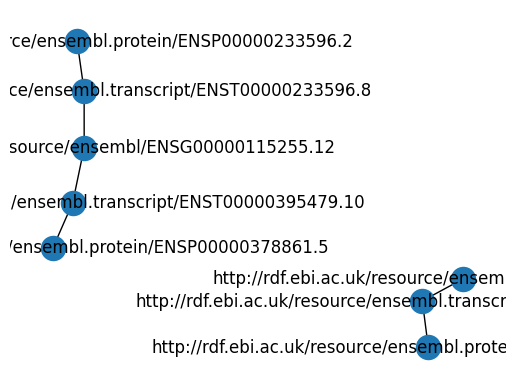

In [56]:
# Plot Networkx instance of RDF Graph
pos = nx.spring_layout(G, scale=2)
edge_labels = nx.get_edge_attributes(G, 'r')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, with_labels=True)

#if not in interactive mode for 
plt.show()

## Data query

In [72]:
query = '''SELECT DISTINCT ?protein ?proteinLabel
WHERE 
{
  ?protein rdfs:seeAlso ?transcript .
  ?protein a up:Protein .
  ?protein up:reviewed true .
  ?protein up:organism taxon:9606 .
  ?protein up:mnemonic ?proteinLabel .
}
'''

In [73]:
q=f'''
{prefixes}
{query}
'''

In [79]:
df = kg.query_to_pandas(q)

In [80]:
df

,protein,proteinLabel
0,http://purl.uniprot.org/uniprot/Q96HR9,REEP6_HUMAN
1,http://purl.uniprot.org/uniprot/Q9BZ11,ADA33_HUMAN
2,http://purl.uniprot.org/uniprot/A6NCL2,LRCL1_HUMAN
3,http://purl.uniprot.org/uniprot/A6NF34,ANTRL_HUMAN
4,http://purl.uniprot.org/uniprot/A6NFU8,PGPIL_HUMAN
...,...,...
20417,http://purl.uniprot.org/uniprot/Q9H7M6,ZSWM4_HUMAN
20418,http://purl.uniprot.org/uniprot/Q9HCJ5,ZSWM6_HUMAN
20419,http://purl.uniprot.org/uniprot/Q6ZMY9,ZN517_HUMAN
20420,http://purl.uniprot.org/uniprot/Q8TB69,ZN519_HUMAN


## Omics

In [ ]:
n_samples = 10
n_

## StellarGraph

In [83]:
!{sys.executable} -m pip install stellargraph[demos] tensorflow

ERROR: Could not find a version that satisfies the requirement stellargraph[demos] (from versions: none)
ERROR: No matching distribution found for stellargraph[demos]


In [1]:
import stellargraph as sg
import tensorflow as tf

2023-06-29 03:39:15.456895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 03:39:15.631622: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-29 03:39:15.659799: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-29 03:39:15.659814: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [ ]:
dataset = sg.datasets.Cora()

In [3]:
from IPython.display import display, HTML
display(HTML(dataset.description))

In [4]:
G, node_subjects = dataset.load()



In [7]:
dir(dataset)

['_NUM_FEATURES',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_all_datasets_directory',
 '_create_base_directory',
 '_delete_existing_files',
 '_is_downloaded',
 '_missing_files',
 '_resolve_path',
 '_resolve_unpack_path',
 'base_directory',
 'data_directory',
 'data_subdirectory_name',
 'description',
 'directory_name',
 'download',
 'expected_files',
 'load',
 'name',
 'source',
 'url',
 'url_archive_contains_directory',
 'url_archive_format']

In [5]:
G

In [10]:
G.nodes()

Int64Index([  31336, 1061127, 1106406,   13195,   37879, 1126012, 1107140,
            1102850,   31349, 1106418,
            ...
             626531, 1131180, 1130454, 1131184, 1128974, 1128975, 1128977,
            1128978,  117328,   24043],
           dtype='int64', length=2708)

In [11]:
G.edges()

[(1033, 35),
 (103482, 35),
 (103515, 35),
 (1050679, 35),
 (1103960, 35),
 (1103985, 35),
 (1109199, 35),
 (1112911, 35),
 (1113438, 35),
 (1113831, 35),
 (1114331, 35),
 (1117476, 35),
 (1119505, 35),
 (1119708, 35),
 (1120431, 35),
 (1123756, 35),
 (1125386, 35),
 (1127430, 35),
 (1127913, 35),
 (1128204, 35),
 (1128227, 35),
 (1128314, 35),
 (1128453, 35),
 (1128945, 35),
 (1128959, 35),
 (1128985, 35),
 (1129018, 35),
 (1129027, 35),
 (1129573, 35),
 (1129683, 35),
 (1129778, 35),
 (1130847, 35),
 (1130856, 35),
 (1131116, 35),
 (1131360, 35),
 (1131557, 35),
 (1131752, 35),
 (1133196, 35),
 (1133338, 35),
 (1136814, 35),
 (1137466, 35),
 (1152421, 35),
 (1152508, 35),
 (1153065, 35),
 (1153280, 35),
 (1153577, 35),
 (1153853, 35),
 (1153943, 35),
 (1154176, 35),
 (1154459, 35),
 (116552, 35),
 (12576, 35),
 (128540, 35),
 (132806, 35),
 (135130, 35),
 (141342, 35),
 (141347, 35),
 (148170, 35),
 (15670, 35),
 (1688, 35),
 (175291, 35),
 (178727, 35),
 (18582, 35),
 (190697, 35),


In [8]:
node_subjects

31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2708, dtype: object

### Custom data

In [ ]:
# convert the raw data into StellarGraph's graph format for faster operations
graph = sg.StellarGraph(nodes, edges)

In [ ]:
generator = sg.mapper.FullBatchNodeGenerator(graph, method="gcn")

# two layers of GCN, each with hidden dimension 16
gcn = sg.layer.GCN(layer_sizes=[16, 16], generator=generator)
x_inp, x_out = gcn.in_out_tensors() # create the input and output TensorFlow tensors

# use TensorFlow Keras to add a layer to compute the (one-hot) predictions
predictions = tf.keras.layers.Dense(units=len(ground_truth_targets.columns), activation="softmax")(x_out)

# use the input and output tensors to create a TensorFlow Keras model
model = tf.keras.Model(inputs=x_inp, outputs=predictions)